# Disease prediction from microbiome structure using ML

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

In [ ]:
# # Download abundance data from GMrepo

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "superkingdom2descendents.txt.gz")
# print("taxonomy table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "samples_loaded.txt.gz")
# print("sample table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample_to_run_info.txt.gz")
# print("sample run download finished)
      
# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "species_abundance.txt.gz")
# print("abundance table download finished)

In [38]:
#import data

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype = 'str')

In [39]:
# using only genus for this project

abundance_genus  = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

In [40]:
# reformat: rownames are samples and colnames are taxa

pivoted_df = abundance_genus.pivot_table(index='loaded_uid', columns='ncbi_taxon_id', values='relative_abundance', fill_value=0)

In [41]:
# rename colnames with actual genus names

# Replace blanks with underscores in the scientific_name column
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')

# Create a mapping between ncbi_taxon_id and scientific_name
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))

# Rename columns in pivoted_df based on the mapping
pivoted_df.rename(columns=mapping, inplace=True)

In [42]:
pivoted_df #taxonomy table is incomplete... must complete later with newer ncbi tax tables

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
1,0.29633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.36680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.13739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.32762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,9.70667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,1.01729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,3.61897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#merge metadata into a single df

metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

In [48]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
0,1,PRJDB4360,NaN,Japanese001,Healthy Japanese gut microbiota,NaN,DRR048993,NaN,SAMD00042843,Amplicon,...,NaN,NaN,6339,DRR048993,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
1,1,PRJDB4360,NaN,Japanese002,Healthy Japanese gut microbiota,NaN,DRR048994,NaN,SAMD00042844,Amplicon,...,NaN,NaN,6340,DRR048994,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
2,1,PRJDB4360,NaN,Japanese003,Healthy Japanese gut microbiota,NaN,DRR048995,NaN,SAMD00042845,Amplicon,...,NaN,NaN,6341,DRR048995,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
3,1,PRJDB4360,NaN,Japanese004,Healthy Japanese gut microbiota,NaN,DRR048996,NaN,SAMD00042846,Amplicon,...,NaN,NaN,6342,DRR048996,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
4,1,PRJDB4360,NaN,Japanese005,Healthy Japanese gut microbiota,NaN,DRR048997,NaN,SAMD00042847,Amplicon,...,NaN,NaN,6343,DRR048997,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


In [49]:
# Data cleaning

# 1) Remove rows where QCStatus is equal to 0
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]

# 2) Remove rows with a phenotype value_count < 100
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]


In [50]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
326,1,PRJDB4360,NaN,Japanese327,Healthy Japanese gut microbiota,NaN,DRR049319,NaN,SAMD00043169,Amplicon,...,NaN,NaN,6791,DRR049319,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
726,1,PRJDB4998,NaN,YB_51,Microbiota of the fecal sample from subject 51,NaN,DRR067938,NaN,SAMD00058143,Amplicon,...,NaN,NaN,8905,DRR067938,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
914,1,PRJDB4998,NaN,YB_239,Microbiota of the fecal sample from subject 239,NaN,DRR068126,NaN,SAMD00058331,Amplicon,...,NaN,NaN,8906,DRR068126,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
916,1,PRJDB4998,NaN,YB_241,Microbiota of the fecal sample from subject 241,NaN,DRR068128,NaN,SAMD00058333,Amplicon,...,NaN,NaN,8907,DRR068128,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
1261,1,PRJDB4360,NaN,Japanese401,Healthy Japanese gut microbiota,NaN,DRR092034,NaN,SAMD00079898,Amplicon,...,NaN,NaN,6792,DRR092034,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


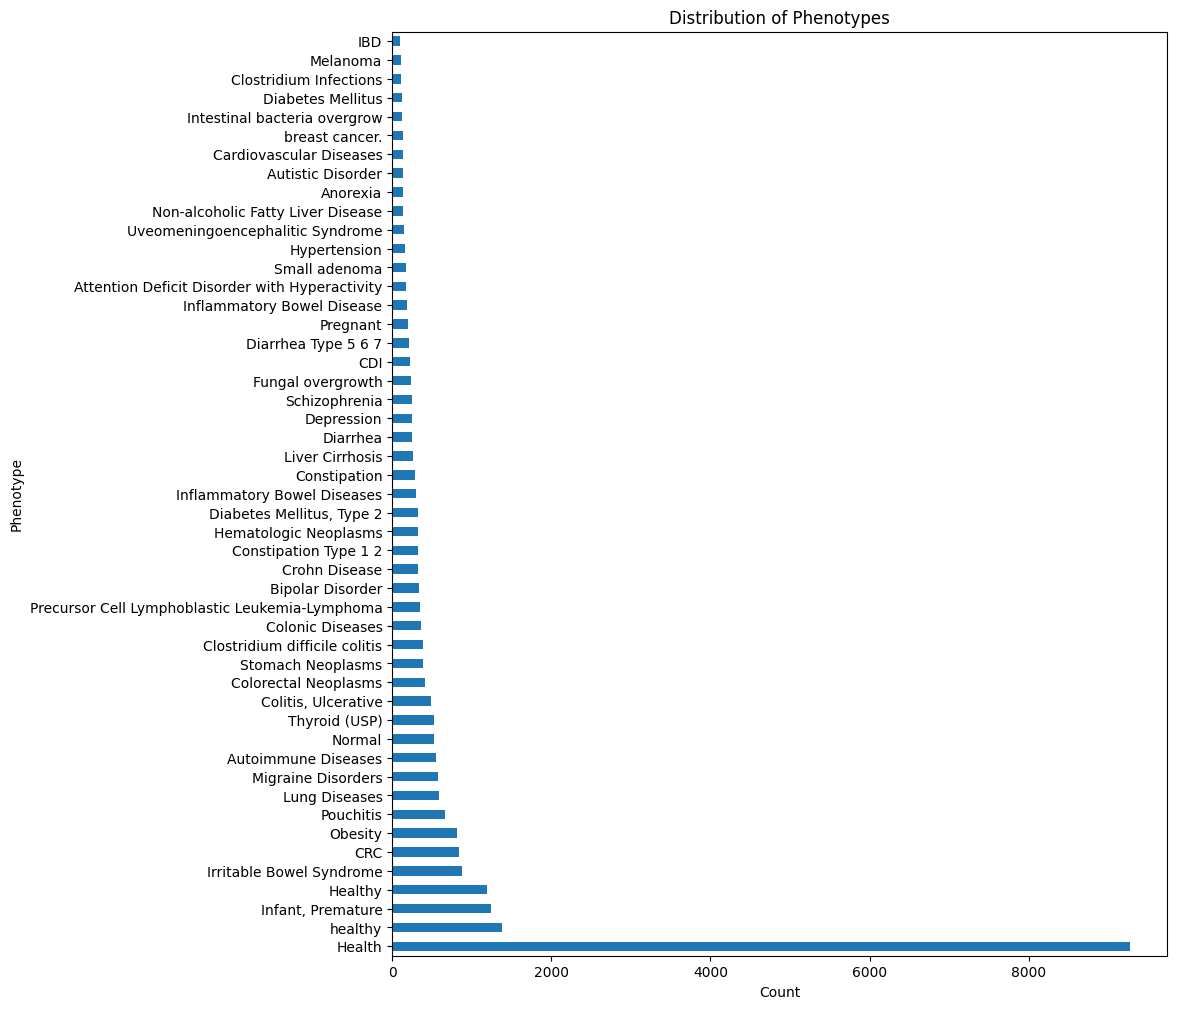

In [51]:
plt.figure(figsize=(10, 12))

# Create a horizontal barplot of the 'phenotype' column
metadata_df['phenotype'].value_counts().plot(kind='barh')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes')

# Show the plot
plt.show()

In [23]:
# group Healthy, healthy, health, Normal? keep only [Hh]ealthy?
# group IBD with Inflamaroty Bowel Disease

# subsample *healthy* group (PCA, sample selection, capture as much variance as possible and elimiante redundancies)

In [67]:
# keep only good samples

uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[uids_to_keep]

In [68]:
pivoted_df_filtered

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
6791,61.2298,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8905,26.8026,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8906,28.3489,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8907,31.9803,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6792,11.2369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,97.9051,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6060,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7342,16.1821,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
phenotype_labels = metadata_df[["phenotype", "uid"]]

### PCA 

In [83]:
phenotype_labels

,phenotype,uid
326,Health,6791
726,Health,8905
914,Health,8906
916,Health,8907
1261,Health,6792
...,...,...
53303,Health,6008
53304,Health,6060
53305,Health,7342
53306,Health,6054


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

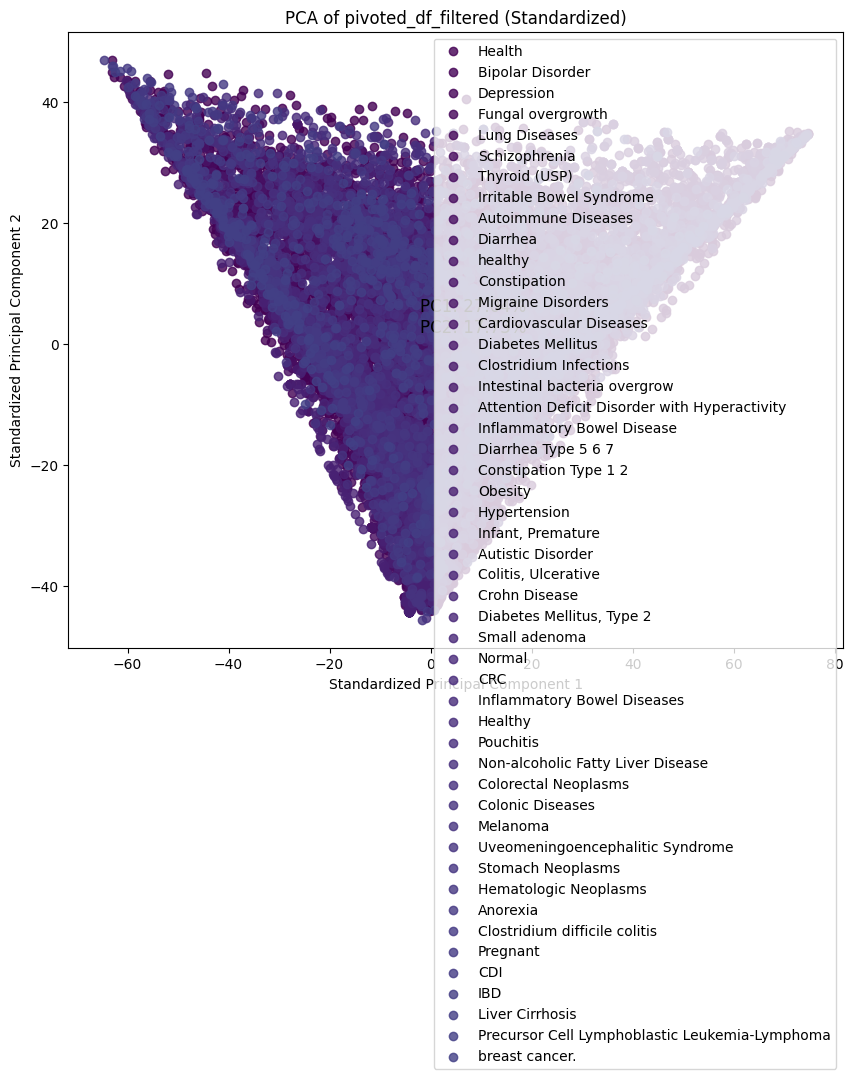

In [90]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Convert column names to strings
pivoted_df_filtered.columns = pivoted_df_filtered.columns.astype(str)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_filtered)


# Create a DataFrame with standardized PCA results and labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Label'] = phenotype_labels["phenotype"].values

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Manually assign colors for each phenotype
unique_phenotypes = phenotype_labels["phenotype"].unique()
colors = plt.cm.viridis(range(len(unique_phenotypes)))

# Loop through unique phenotypes for coloring and legend
for phenotype, color in zip(unique_phenotypes, colors):
    subset_df = pca_df[pca_df['Label'] == phenotype]
    plt.scatter(subset_df['PC1'], subset_df['PC2'], label=phenotype, c=color, alpha=0.8)

plt.title('PCA of pivoted_df_filtered (Standardized)')
plt.xlabel('Standardized Principal Component 1')
plt.ylabel('Standardized Principal Component 2')

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.text(-2, 2, f'PC1: {explained_var_ratio[0]*100:.2f}%\nPC2: {explained_var_ratio[1]*100:.2f}%', fontsize=12)

# Add legend
plt.legend()

plt.show()
